# Brain–Heart Coupling Study Notebook

This notebook walks through the full pipeline you asked for, in **ordered, well‑commented steps**:

1. Background on Poincaré plot and HRV indices (SD1, SD2, CSI, CVI).
2. Synthetic data generation (EEG band power + inter-beat intervals).
3. Implementation of sliding-window Poincaré metrics (time‑resolved CSI/CVI).
4. Visualization: raw IBI, Poincaré scatter, fitted ellipse, CSI/CVI time series.
5. Coupling model translation (ARX‑based Heart→Brain; normalized Cs/Cp Brain→Heart).
6. Execution of the full model and inspection of outputs.
7. Interpretative notes & next steps.

You can study each cell independently; heavy inline comments explain rationale and math.

## 1. Poincaré Plot Background
The Poincaré plot places successive inter-beat intervals (IBI_n, IBI_{n+1}) as points in 2D. Key dispersion axes:
- SD1: Standard deviation perpendicular to the line of identity (short-term variability).
- SD2: Standard deviation along the line of identity (long-term variability).
Derived indices (one common convention):
- CSI = SD2 / SD1 (cardiac sympathetic index).
- CVI = log10(SD1 * SD2) (cardiac vagal index).
We compute them **per sliding window** to obtain time-resolved series aligned with EEG features.

In [1]:
# 2. Imports & utility setup
import numpy as np
import math
import matplotlib.pyplot as plt
try:
    from scipy.interpolate import CubicSpline
    _HAS_SCIPY = True
except ImportError:
    _HAS_SCIPY = False

plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['axes.grid'] = True

def _interp(x_t, x, new_t):
    if len(x_t) < 2: return np.full_like(new_t, np.nan, dtype=float)
    if _HAS_SCIPY and len(x_t) >= 4:
        return CubicSpline(x_t, x)(new_t)
    return np.interp(new_t, x_t, x)

def arx_b_coefficient(y, u):
    """Estimate b1 for ARX(1,1,1): y_t = a1*y_{t-1} + b1*u_{t-1} + c + e_t"""
    y = np.asarray(y, float); u = np.asarray(u, float)
    if y.ndim!=1 or u.ndim!=1 or y.size!=u.size or y.size<3: return np.nan
    Y = y[1:]; Ylag = y[:-1]; Ulag = u[:-1]; X = np.column_stack([Ylag, Ulag, np.ones_like(Ylag)])
    try:
        coeffs,_res,_rank,_s = np.linalg.lstsq(X, Y, rcond=None)
        return float(coeffs[1])
    except np.linalg.LinAlgError:
        return np.nan

def clean_artif(eeg):
    # Placeholder: apply artifact rejection / filtering if needed.
    return eeg

print('Imports complete. SciPy cubic interpolation available:' , _HAS_SCIPY)

Imports complete. SciPy cubic interpolation available: True


In [2]:
# 3. Synthetic data generation
np.random.seed(7)
Fs = 4.0          # EEG sampling (Hz) for band-power time base
wind_sec = 15.0   # window length for Poincaré & coupling
T_sec = 300.0     # total duration
Nt = int(T_sec * Fs)
time = np.arange(Nt)/Fs
Nch = 2           # number of EEG channels/bands

# EEG band-power: smooth oscillation + noise, differing baselines
EEG_comp = []
for ch in range(Nch):
    slow = 1 + 0.3*ch + 0.6*np.sin(2*np.pi*0.01*time)
    noise = 0.12*np.random.randn(Nt)
    EEG_comp.append(slow + noise)
EEG_comp = np.vstack(EEG_comp)

# Inter-beat intervals (IBI) via stochastic heart rate around 1.05 Hz (~63 bpm)
hr_mean = 1.05
t_IBI = [0.0]; IBI = []
while t_IBI[-1] < T_sec:
    interval = np.random.normal(1/hr_mean, 0.05)
    if interval <= 0: interval = 1/hr_mean
    IBI.append(interval); t_IBI.append(t_IBI[-1] + interval)
IBI = np.array(IBI); t_IBI = np.array(t_IBI[:-1])

# Baseline synthetic CSI/CVI (global trend) – will be refined by windowed computation later
CSI_base = 2 + 0.25*np.sin(2*np.pi*0.004*time) + 0.08*np.random.randn(Nt)
CVI_base = 1.6 + 0.20*np.cos(2*np.pi*0.006*time) + 0.07*np.random.randn(Nt)

print('Synthetic EEG_comp shape:', EEG_comp.shape)
print('IBI count:', IBI.size, 'Duration last timestamp:', t_IBI[-1])

Synthetic EEG_comp shape: (2, 1200)
IBI count: 314 Duration last timestamp: 299.2086421137092


In [3]:
# 4. Sliding-window Poincaré computation (time-resolved CSI/CVI)
def compute_csi_cvi(IBI, t_IBI, Fs_target=4.0, wind_sec=15.0):
    """Compute time-resolved CSI & CVI using sliding windows over raw IBI.

    Corrected implementation (previous draft stalled due to mistaken array reassignment).
    Steps:
      1. Slide a window of length wind_sec in 1 s steps across t_IBI.
      2. For each window with >=4 beats compute SD1/SD2:
         SD1 = sqrt(0.5)*std(diff(IBI_win))
         SD2 = sqrt( 2*std(IBI_win)^2 - 0.5*std(diff(IBI_win))^2 )
      3. Map to CSI = SD2/SD1, CVI = log10(SD1*SD2).
      4. Interpolate to uniform Fs_target grid restricted to overlap.

    Returns:
      t_out        : uniform time vector
      CSI_out,CVI_out : interpolated CSI/CVI
      centers      : raw window center timestamps
      CSI_win,CVI_win : raw (non-interpolated) window values
    """
    IBI = np.asarray(IBI, float); t_IBI = np.asarray(t_IBI, float)
    if IBI.size < 4: raise ValueError('Need >=4 IBI samples')
    win = float(wind_sec)
    step = 1.0  # seconds
    start_t = t_IBI[0]
    end_t = t_IBI[-1] - win
    centers = []
    CSI_win = []
    CVI_win = []
    t_cursor = start_t
    while t_cursor <= end_t:
        t1 = t_cursor
        t2 = t_cursor + win
        mask = (t_IBI >= t1) & (t_IBI <= t2)
        if np.sum(mask) >= 4:
            seg = IBI[mask]
            diff_seg = np.diff(seg)
            sd_diff = np.std(diff_seg, ddof=1)
            sd_all  = np.std(seg, ddof=1)
            SD1 = math.sqrt(0.5)*sd_diff
            SD2 = math.sqrt(2*sd_all**2 - 0.5*sd_diff**2)
            CSI = SD2/SD1 if SD1>0 else np.nan
            CVI = math.log10(SD1*SD2) if SD1>0 and SD2>0 else np.nan
        else:
            CSI = np.nan; CVI = np.nan
        centers.append(t1 + win/2.0)
        CSI_win.append(CSI)
        CVI_win.append(CVI)
        t_cursor += step
    centers = np.array(centers)
    CSI_win = np.array(CSI_win)
    CVI_win = np.array(CVI_win)
    if centers.size < 3: raise ValueError('Too few windows computed for interpolation')
    # Uniform target grid
    t_uniform = np.arange(math.floor(t_IBI[0]), math.ceil(t_IBI[-1])+1/Fs_target, 1/Fs_target)
    t_start = max(t_uniform[0], centers[0])
    t_stop  = min(t_uniform[-1], centers[-1])
    valid_mask = (t_uniform >= t_start) & (t_uniform <= t_stop)
    t_out = t_uniform[valid_mask]
    CSI_out = _interp(centers, CSI_win, t_out)
    CVI_out = _interp(centers, CVI_win, t_out)
    return t_out, CSI_out, CVI_out, centers, CSI_win, CVI_win

# Run corrected function
t_csi, CSI_series, CVI_series, win_centers, CSI_raw, CVI_raw = compute_csi_cvi(IBI, t_IBI, Fs_target=Fs, wind_sec=wind_sec)
print('Computed CSI/CVI series length:', CSI_series.size)
print('First 5 CSI values:', CSI_series[:5])

Computed CSI/CVI series length: 1137
First 5 CSI values: [0.94678156 0.88836885 0.85023362 0.82816005 0.81793232]


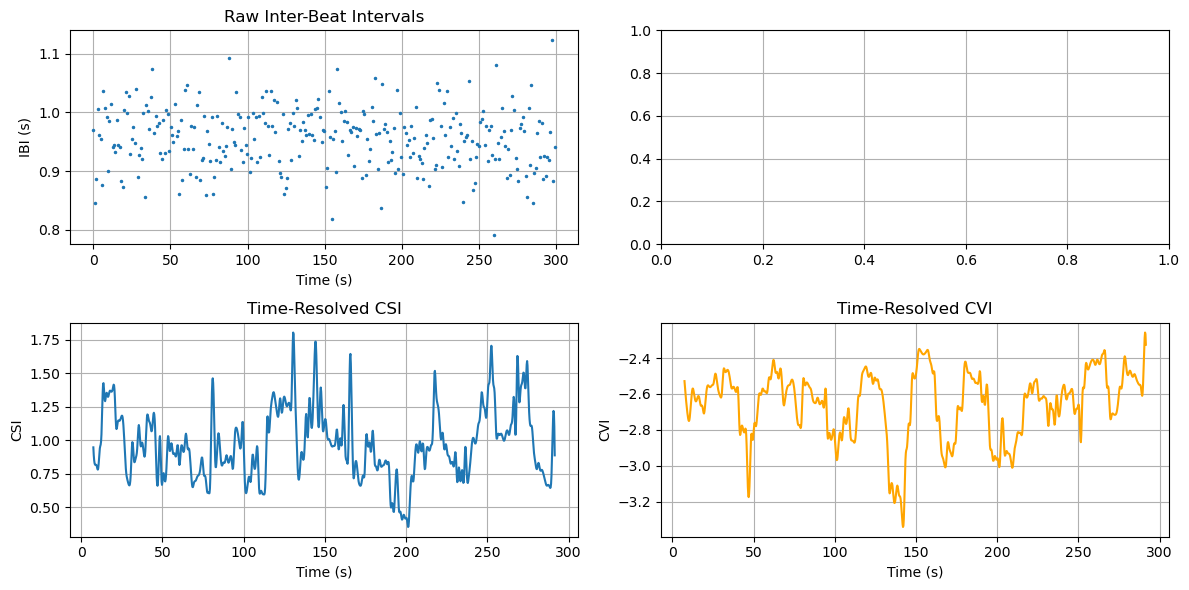

In [4]:
# 5. Visualization of IBI, Poincaré cloud, and time-resolved indices
fig, axs = plt.subplots(2,2, figsize=(12,6))
# Raw IBI over time
axs[0,0].plot(t_IBI, IBI, '.', ms=3)
axs[0,0].set_title('Raw Inter-Beat Intervals')
axs[0,0].set_xlabel('Time (s)'); axs[0,0].set_ylabel('IBI (s)')

# Single-window Poincaré cloud (use middle window)
mid_idx = len(win_centers)//2
mid_center = win_centers[mid_idx]
# Time-resolved CSI
axs[1,0].plot(t_csi, CSI_series, label='CSI')
axs[1,0].set_title('Time-Resolved CSI')
axs[1,0].set_xlabel('Time (s)'); axs[1,0].set_ylabel('CSI')
# Time-resolved CVI
axs[1,1].plot(t_csi, CVI_series, color='orange', label='CVI')
axs[1,1].set_title('Time-Resolved CVI')
axs[1,1].set_xlabel('Time (s)'); axs[1,1].set_ylabel('CVI')
plt.tight_layout(); plt.show()

In [7]:
# 6. Coupling model (HRV Cs/Cp + ARX directional indices)
def compute_cs_cp(time, IBI, t_IBI, Fs, wind_sec):
    f_lf, f_hf = 0.1, 0.25
    w_lf, w_hf = 2*np.pi*f_lf, 2*np.pi*f_hf
    window = int(round(wind_sec*Fs))
    ss = window; sc = 1; nt = max(int(np.ceil((len(time)-ss)/sc)),1)
    Cs = np.zeros(nt); Cp = np.zeros(nt); TM = np.zeros(nt)
    for i in range(nt):
        ix1 = i*sc; ix2 = min(ix1 + ss -1, len(time)-1); ixm = (ix1+ix2)//2
        t1 = time[ix1]; t2 = time[ix2]
        mask = (t_IBI >= t1) & (t_IBI <= t2)
        if np.sum(mask) < 4: Cs[i]=np.nan; Cp[i]=np.nan; TM[i]=time[ixm]; continue
        seg = IBI[mask]; mu_ibi = np.mean(seg); mu_hr = 1/mu_ibi if mu_ibi>0 else np.nan
        if not np.isfinite(mu_hr): Cs[i]=np.nan; Cp[i]=np.nan; TM[i]=time[ixm]; continue
        s_hf = np.sin(w_hf/(2*mu_hr)); s_lf = np.sin(w_lf/(2*mu_hr))
        if abs(s_hf)<1e-9 or abs(s_lf)<1e-9: Cs[i]=np.nan; Cp[i]=np.nan; TM[i]=time[ixm]; continue
        G = s_hf - s_lf
        M_11 = s_hf*w_lf*mu_hr/(s_lf*4); M_12 = -np.sqrt(2)*w_lf*mu_hr/(8*s_lf)
        M_21 = -s_lf*w_hf*mu_hr/(s_hf*4); M_22 = np.sqrt(2)*w_hf*mu_hr/(8*s_hf)
        M = np.array([[M_11, M_12],[M_21, M_22]])
        L = np.max(seg)-np.min(seg); dI = np.abs(np.diff(seg)); W = np.sqrt(2)*(np.max(dI) if dI.size>0 else 0)
        C = (1/G)*M @ np.array([L,W])
        Cs[i]=C[0]; Cp[i]=C[1]; TM[i]=time[ixm]
    good = np.isfinite(TM); return TM[good], Cs[good], Cp[good]

def model_sdg_psv(EEG_comp, CSI, CVI, IBI, t_IBI, Fs, time, wind_sec):
    EEG_comp = np.asarray(EEG_comp,float); Nch,Nt = EEG_comp.shape
    TM, Cs, Cp = compute_cs_cp(time, IBI, t_IBI, Fs, wind_sec)
    # Align time bases
    t1 = max(time[0], TM[0]); t2 = min(time[-1], TM[-1])
    mask_t = (time>=t1) & (time<=t2); time2 = time[mask_t]
    Cs_i = _interp(TM, Cs, time2); Cp_i = _interp(TM, Cp, time2)
    CSI_i = _interp(time, CSI, time2); CVI_i = _interp(time, CVI, time2)
    EEG_al = np.zeros((Nch, time2.size))
    for ch in range(Nch): EEG_al[ch] = _interp(time[mask_t], EEG_comp[ch, mask_t], time2)
    EEG_al = clean_artif(EEG_al)
    window = int(round(wind_sec*Fs))
    CSI2B=[]; CVI2B=[]; B2CSI=[]; B2CVI=[]
    for ch in range(Nch):
        csi_b, cvi_b, b2csi, b2cvi = SDG_channel(EEG_al[ch], CSI_i, CVI_i, Cs_i, Cp_i, window)
        CSI2B.append(csi_b); CVI2B.append(cvi_b); B2CSI.append(b2csi); B2CVI.append(b2cvi)
    CSI2B = np.vstack(CSI2B); CVI2B = np.vstack(CVI2B); B2CSI = np.vstack(B2CSI); B2CVI = np.vstack(B2CVI)
    tH2B = time2[:time2.size-window]; tB2H = time2[window: time2.size-window]
    return CSI2B, CVI2B, B2CSI, B2CVI, tH2B, tB2H, time2

def SDG_channel(EEG_ch, CSI_i, CVI_i, Cs_i, Cp_i, window):
    Nt = EEG_ch.size
    CSI_to = np.full(Nt, np.nan); CVI_to = np.full(Nt, np.nan); pow_eeg = np.full(Nt, np.nan)
    limit = min(len(Cp_i), Nt - window, len(CSI_i) - window)
    # Heart->Brain ARX coefficients and local mean power
    for i in range(0, max(limit,0)):
        j2 = min(i+window, Nt-1); y = EEG_ch[i:j2+1]; u_csi = CSI_i[i:j2+1]; u_cvi = CVI_i[i:j2+1]
        CSI_to[i] = arx_b_coefficient(y, u_csi); CVI_to[i] = arx_b_coefficient(y, u_cvi); pow_eeg[i] = np.mean(y)
    # Brain->Heart normalized Cs/Cp by local power over trailing window
    max_len = max(0, limit - window)
    EEG_to_CSI = np.full(max_len if max_len>0 else 1, np.nan)
    EEG_to_CVI = np.full(max_len if max_len>0 else 1, np.nan)
    for k,i in enumerate(range(window, limit)):
        start = i - window; end = i
        denom = pow_eeg[start:end+1]
        denom = np.where(denom==0, np.nan, denom)
        EEG_to_CSI[k] = np.nanmean(Cs_i[start:end+1] / denom)
        EEG_to_CVI[k] = np.nanmean(Cp_i[start:end+1] / denom)
        if k>0:
            if not np.isfinite(EEG_to_CSI[k]): EEG_to_CSI[k] = EEG_to_CSI[k-1]
            if not np.isfinite(EEG_to_CVI[k]): EEG_to_CVI[k] = EEG_to_CVI[k-1]
    return CSI_to, CVI_to, EEG_to_CSI, EEG_to_CVI

print('Coupling model functions defined.')

Coupling model functions defined.


In [11]:
# 7. Run full coupling pipeline using time-resolved CSI/CVI computed earlier
CSI_on_time = _interp(t_csi, CSI_series, time)
CVI_on_time = _interp(t_csi, CVI_series, time)
CSI2B, CVI2B, B2CSI, B2CVI, tH2B, tB2H, time_aligned = model_sdg_psv(EEG_comp, CSI_on_time, CVI_on_time, IBI, t_IBI, Fs, time, wind_sec)
print('Shapes -> CSI2B:', CSI2B.shape, 'CVI2B:', CVI2B.shape, 'B2CSI:', B2CSI.shape, 'B2CVI:', B2CVI.shape)

Shapes -> CSI2B: (2, 1140) CVI2B: (2, 1140) B2CSI: (2, 1020) B2CVI: (2, 1020)


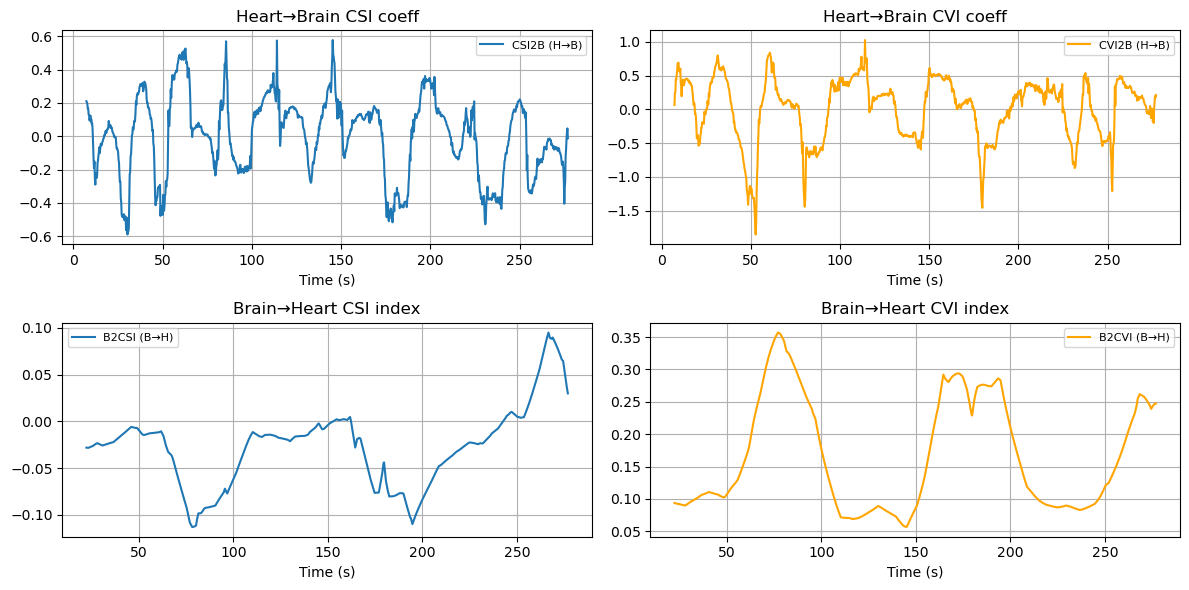

In [12]:
# 8. Plot sample channel results
ch = 0
fig, axs = plt.subplots(2,2, figsize=(12,6))
axs[0,0].plot(tH2B, CSI2B[ch,:len(tH2B)], label='CSI2B (H→B)'); axs[0,0].set_title('Heart→Brain CSI coeff'); axs[0,0].set_xlabel('Time (s)')
axs[0,1].plot(tH2B, CVI2B[ch,:len(tH2B)], color='orange', label='CVI2B (H→B)'); axs[0,1].set_title('Heart→Brain CVI coeff'); axs[0,1].set_xlabel('Time (s)')
axs[1,0].plot(tB2H, B2CSI[ch,:len(tB2H)], label='B2CSI (B→H)'); axs[1,0].set_title('Brain→Heart CSI index'); axs[1,0].set_xlabel('Time (s)')
axs[1,1].plot(tB2H, B2CVI[ch,:len(tB2H)], color='orange', label='B2CVI (B→H)'); axs[1,1].set_title('Brain→Heart CVI index'); axs[1,1].set_xlabel('Time (s)')
for a in axs.flatten(): a.legend(fontsize=8)
plt.tight_layout(); plt.show()

## 9. Study Notes & Caveats
- The synthetic data are simplistic; real EEG band-power extraction requires preprocessing (filtering, artifact cleaning).
- Poincaré SD1/SD2 definitions vary slightly across papers; we used a common closed-form. Scaling factors won't affect *ratios/logs*.
- ARX coefficient stability depends on window length; very small windows produce noisy estimates.
- Brain→Heart normalization divides Cs/Cp by local mean EEG power; alternative formulations could standardize by variance or apply z-scores.
- Interpolation may introduce smoothing—ensure sampling rates are adequate and avoid extrapolation beyond overlap.
- For production, add: input validation, artifact rejection, optional parallelization, confidence intervals (bootstrap).

### Next Steps
1. Replace synthetic data with real IBI + EEG band-power.
2. Add statistical significance testing (surrogate / phase-randomized null).
3. Port functions into a reusable Python module with unit tests.
4. Integrate with BIDS loader for automated preprocessing.

Feel free to ask for deeper dives or modifications (e.g., add surrogate analysis).